# Deep Convolutional Generative Adversarial Network

Source: https://www.tensorflow.org/tutorials/generative/dcgan

## Import dependencies

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
import platform
import imageio
import PIL
import time
import os
import glob

from IPython import display

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.6
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


## Load data

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [6]:
print('train_images.shape: ', train_images.shape)
print('train_labels.shape: ', train_images.shape)

train_images.shape:  (60000, 28, 28)
train_labels.shape:  (60000, 28, 28)


In [7]:
print(train_labels[0])

5


In [8]:
print(train_images[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

## Reshape and normalize data

In [9]:
train_images_reshaped = train_images.reshape(
    train_images.shape[0],
    train_images.shape[1],
    train_images.shape[2],
    1
).astype('float32')

In [12]:
print('train_images_reshaped.shape: ', train_images_reshaped.shape)

train_images_reshaped.shape:  (60000, 28, 28, 1)


In [13]:
# Normalize the images to [-1, 1]
train_images_normalized = (train_images_reshaped - 127.5) / 127.5

In [14]:
print(train_images_normalized[0])

[[[-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]]

 [[-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]]

 [[-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-

In [15]:
SHUFFLE_BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images_normalized) \
    .shuffle(SHUFFLE_BUFFER_SIZE) \
    .batch(BATCH_SIZE)

print(train_dataset)

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


## Create models

### Create generator

In [30]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    # Step 1.
    model.add(tf.keras.layers.Dense(
        units=7*7*256,
        use_bias=False,
        input_shape=(100,)
    ))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    # Step 2.
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # None is a batch size.
    
    # Step 3.
    model.add(tf.keras.layers.Conv2DTranspose(
        filters=128,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding='same',
        use_bias=False
    ))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    # Step 4.
    model.add(tf.keras.layers.Conv2DTranspose(
        filters=64,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding='same',
        use_bias=False
    ))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    # Step 5.
    model.add(tf.keras.layers.Conv2DTranspose(
        filters=1,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding='same',
        use_bias=False,
        activation='tanh'
    ))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

In [31]:
generator_model = make_generator_model()

In [32]:
generator_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)        

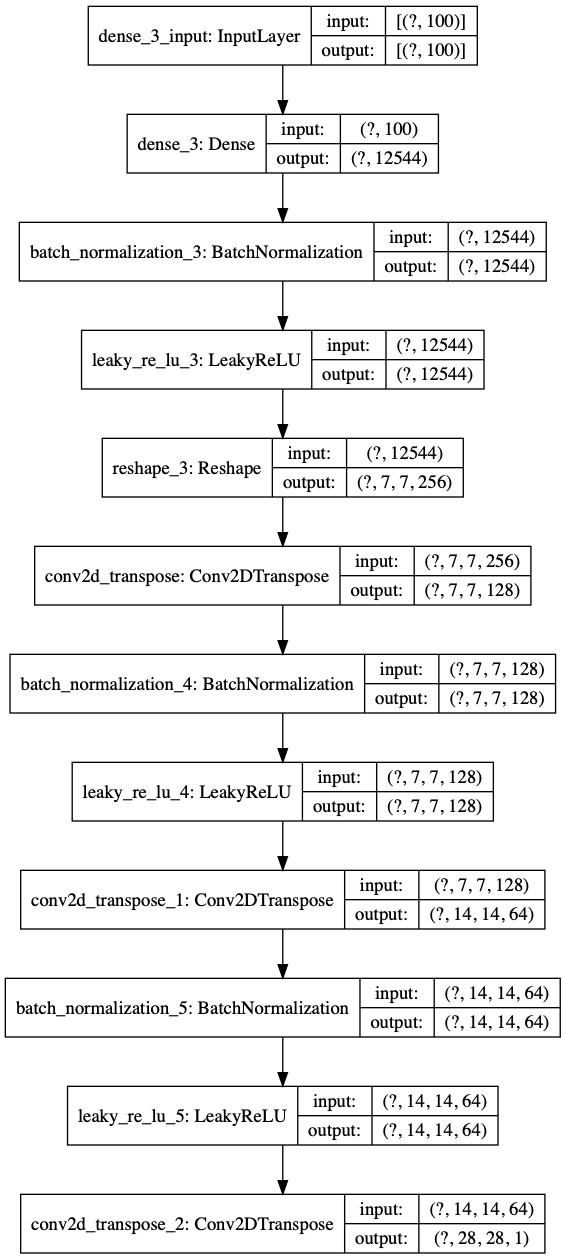

In [49]:
tf.keras.utils.plot_model(
    generator_model,
    show_shapes=True,
    show_layer_names=True,
    to_file='generator_model.png'
)

In [37]:
noise = tf.random.normal(shape=[1, 100])

print(noise.numpy())

[[-0.16570316  0.29458502  1.5609475   0.07669373 -0.2018238  -1.3724824
  -0.58483815 -0.67554516  1.210547    2.0317461   1.4335974   1.566116
   1.2057879  -0.7313886   0.55647933 -1.1143767  -1.0397354   0.8580305
   0.6472558  -1.0419825   0.8108177  -0.14687416  0.64386636  1.3795191
   0.16223304 -1.4024717   1.1273937   0.35012877 -0.10622495 -0.20710707
   2.1517344   0.37328172  0.00502483 -1.1269348   0.82692     1.7129478
   0.03853795 -1.4768853  -0.38560206  0.8663881   3.1975927  -1.1634874
   0.03007143 -0.85455066 -0.5276984   1.7052486  -1.1780007   1.0920072
  -2.0766685  -1.3138379   0.40346384 -0.45057127 -1.496518   -0.09348098
   0.12706739 -0.2069611   0.16523455  0.23865786 -0.8749046  -0.85919964
  -0.6791307   0.24866155 -0.6035103   0.98245585  0.45686015 -0.793887
   0.35647643  0.42158616  1.3517041  -0.6216338  -1.5092978   0.8324507
   0.9383308  -0.4864083  -0.7395954   0.8802629   2.0720336  -0.4415254
   0.2795918  -0.46488118  2.249853   -0.2526843  

In [39]:
generated_image = generator_model(noise, training=False)

print('generated_image.shape: ', generated_image.shape)

generated_image.shape:  (1, 28, 28, 1)


In [42]:
print(generated_image[0, :, :, 0].numpy())

[[ 5.53792249e-03  4.37338749e-04  3.68044991e-03 -3.82861774e-03
   1.64686572e-02  1.08583542e-02  1.31135369e-02 -7.16386177e-03
   2.09171558e-03  8.04766454e-03  1.95016265e-02 -1.38255097e-02
  -8.91560502e-03  1.85460225e-02  7.28042470e-03 -1.20236212e-02
   8.77844926e-04  5.30730886e-03 -4.11776174e-03 -9.16558132e-03
   1.19838296e-02 -6.92816731e-03 -8.63405410e-03 -5.97072067e-03
   8.82987585e-03 -2.45614070e-03  4.94582579e-03 -7.02331588e-03]
 [ 1.27449036e-02  2.43766531e-02  2.53370986e-03 -5.42153046e-03
   1.29412580e-02  1.38436444e-02  1.14870220e-02 -1.82686746e-03
   9.49943997e-03  3.66184413e-02 -2.12774221e-02  6.93519088e-03
   2.07883120e-02  1.39004048e-02 -1.49136912e-02 -3.42820422e-03
   3.12169958e-02  9.97011550e-03 -1.68702416e-02  1.19159883e-02
   3.03527247e-02  2.18404531e-02  1.17653329e-02  1.40293585e-02
   1.84631441e-02  1.33424513e-02 -5.47526311e-03  1.53924739e-02]
 [ 1.11918291e-02 -8.36308021e-03  2.98497546e-03 -1.99313518e-02
   9.266

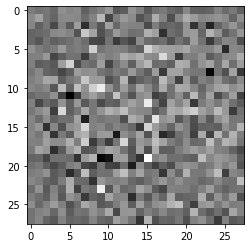

In [44]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Create discriminator

In [45]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    # Step 1.
    model.add(tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding='same',
        input_shape=[28, 28, 1]
    ))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    # Step 2.
    model.add(tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding='same'
    ))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    # Step 3.
    model.add(tf.keras.layers.Flatten())
    
    # Real vs Fake
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [46]:
discriminator_model = make_discriminator_model()

In [47]:
discriminator_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

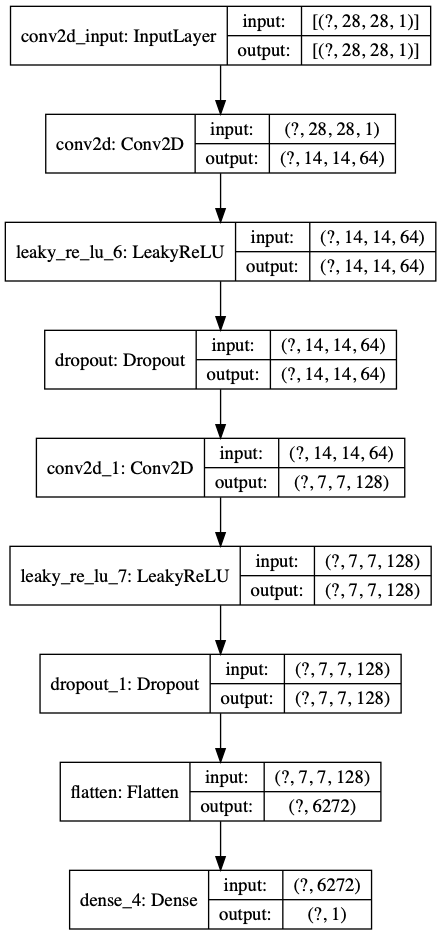

In [50]:
tf.keras.utils.plot_model(
    discriminator_model,
    show_shapes=True,
    show_layer_names=True,
    to_file='discriminator_model.png'
)

In [52]:
dicision = discriminator_model(generated_image)

print(dicision)

tf.Tensor([[0.00034974]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

In [53]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(
    from_logits=True
)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [54]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(
        # true
        tf.ones_like(real_output),
        # predicted
        real_output
    )
    
    fake_loss = cross_entropy(
        # true
        tf.zeros_like(fake_output),
        # predicted
        fake_output
    )
    
    total_loss = real_loss + fake_loss
    
    return total_loss

### Generator loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [55]:
def generator_loss(fake_output):
    return cross_entropy(
        # true
        tf.ones_like(fake_output),
        # predicted
        fake_output
    )

### Optimizers

In [57]:
generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001
)

discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001
)

### Checkpoints

In [75]:
checkpoint_dir = './tmp/ckpt'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator_model=generator_model,
    discriminator_model=discriminator_model
)

## Training

In [80]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 25

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [61]:
# This `tf.function` annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    # Generate input noise.
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images.
        generated_images = generator_model(
            noise,
            training=True
        )
        
        # Detect fake and real images.
        real_output = discriminator_model(
            images,
            training=True
        )
        fake_output = discriminator_model(
            generated_images,
            training=True
        )
        
        # Calculate losses.
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(
            real_output,
            fake_output
        )
    
    # Calculate gradients.
    gradients_of_generator = gen_tape.gradient(
        gen_loss,
        generator_model.trainable_variables
    )
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss,
        discriminator_model.trainable_variables
    )
    
    # Do gradient step.
    generator_optimizer.apply_gradients(zip(
        gradients_of_generator,
        generator_model.trainable_variables
    ))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator,
        discriminator_model.trainable_variables
    ))



In [81]:
def train(dataset, epochs):
    print('Start training...')
    
    for epoch in range(epochs):
        print('  Epoch #{}'.format(epoch + 1))
        
        start = time.time()
        
        step = 0
        for image_batch in dataset:
            step += 1
            print('    Step #{}'.format(step))
            train_step(image_batch)
            
        # Produce images for the GIF as we go.
        display.clear_output(wait=True)
        generate_and_save_images(
            generator_model,
            epoch + 1,
            seed
        )
        
        # Save the model every 10 epochs.
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        print('Time for epoch {} is {}'.format(epoch + 1, time.time() - start))
        
        # Generate after the final epoch.
        display.clear_output(wait=True)
        generate_and_save_images(
            generator_model,
            epoch,
            seed
        )

In [82]:
if not os.path.exists('tmp/imgs/'):
    os.makedirs('tmp/imgs/')

In [83]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    
    fig_dimension = int(math.sqrt(num_examples_to_generate))
    fig = plt.figure(figsize=(fig_dimension, fig_dimension))
    
    for i in range(predictions.shape[0]):
        plt.subplot(fig_dimension, fig_dimension, i+1)
        plt.imshow(
            predictions[i, :, :, 0] * 127.5 + 127.5,
            cmap='gray'
        )
        plt.axis('off')
        
    plt.savefig('tmp/imgs/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

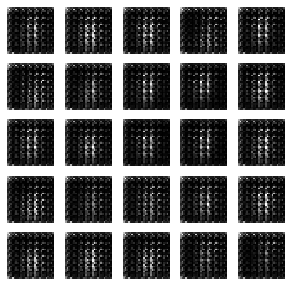

In [84]:
train(train_dataset.take(1), EPOCHS)

In [85]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF

In [86]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('tmp/imgs/image_at_epoch_{:04d}.png'.format(epoch_no))

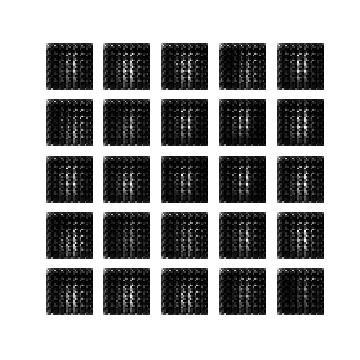

In [87]:
display_image(EPOCHS)

In [90]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('tmp/imgs/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
    image = imageio.imread(filename)
    writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)